In [2]:
!git clone https://github.com/NatanshK/IGEM-IITR-Drylab.git

Cloning into 'IGEM-IITR-Drylab'...
remote: Enumerating objects: 16387, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 16387 (delta 70), reused 35 (delta 8), pack-reused 16259 (from 1)
Receiving objects: 100% (16387/16387), 1.20 GiB | 48.99 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Updating files: 100% (17675/17675), done.


In [4]:
import os
data_dir = '/kaggle/working/IGEM-IITR-Drylab/DATASET_NEW'
print(os.listdir(data_dir))

['HEALTHY', 'REDROT', '.DS_Store']


In [6]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_dir = '/kaggle/working/IGEM-IITR-Drylab/DATASET_NEW/'


transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])


dataset = datasets.ImageFolder(data_dir, transform=transform)


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
cnn_model.fc = nn.Identity()
cnn_model = cnn_model.to(device)
cnn_model.eval()

def extract_features(dataloader, model):
    features_list = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            features = model(inputs)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    return np.vstack(features_list), np.hstack(labels_list)

X_train, y_train = extract_features(train_loader, cnn_model)
X_val, y_val = extract_features(val_loader, cnn_model)
X_test, y_test = extract_features(test_loader, cnn_model)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

rf_classifier = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt'] 
}

grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)

f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f'F1 Score for Random Forest: {f1_rf:.4f}')
print(f'Accuracy for Random Forest: {accuracy_rf:.4f}')


F1 Score for Random Forest: 0.9611
Accuracy for Random Forest: 0.9615


In [18]:
accuracy_percentage = accuracy_rf * 100
print(f'Test Accuracy: {accuracy_percentage:.2f}%')


Test Accuracy: 96.15%


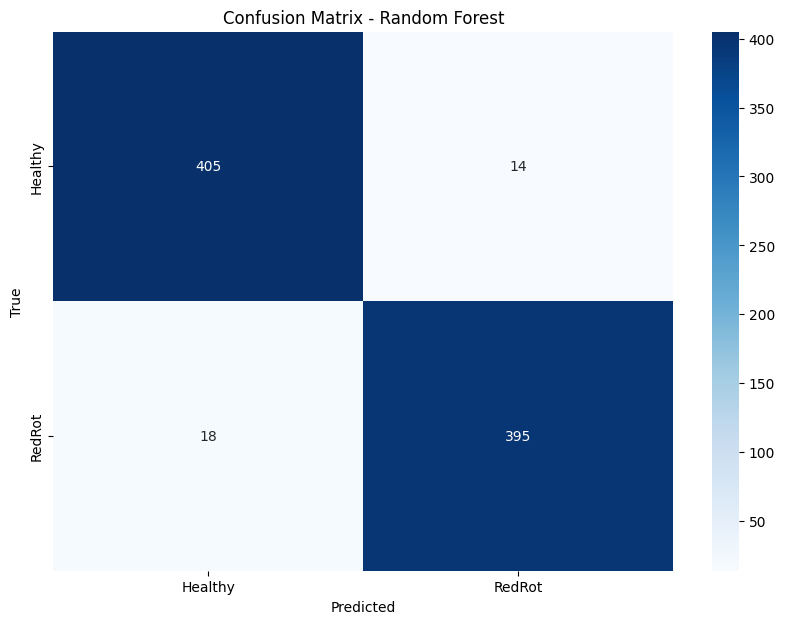

In [19]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', 'RedRot'], yticklabels=['Healthy', 'RedRot'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()


In [20]:
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

precision_rf = precision_score(y_test, y_pred_rf, average='weighted') * 100  
recall_rf = recall_score(y_test, y_pred_rf, average='weighted') * 100 
f1_rf = f1_score(y_test, y_pred_rf, average='weighted') * 100 

print(f'Precision: {precision_rf:.2f}%')
print(f'Recall: {recall_rf:.2f}%')
print(f'F1 Score: {f1_rf:.2f}%')


Precision: 96.16%
Recall: 96.15%
F1 Score: 96.15%


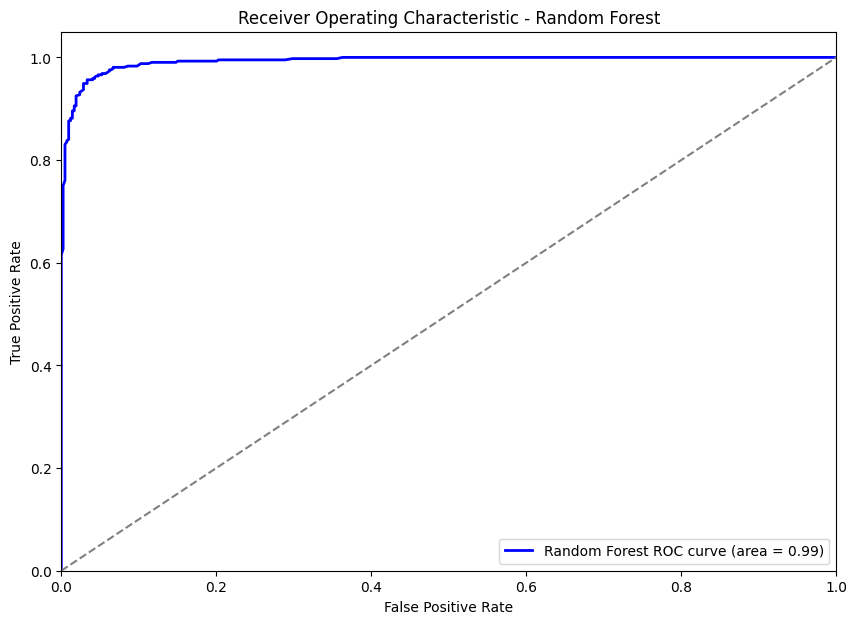

In [21]:
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(10, 7))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc='lower right')
plt.show()
